# Modelling Stickiness based on outputs of Diffusion Limited Aggregation
author: Sarvaswa Tandon

## Approach
1. We shall first visualise the outputs from DLA
2. Note down our observations around stickiness variation based on the visuals
3. Build a mathematical model to model variation of stickiness with any parameters that can be derived from DLA outputs
4. Conclude with the best possible model

## Assumptions
1. In the interest of time, I'll only try 1 parameter / metric that intuitively seems best at the moment.
2. Since DLA takes really long to run, I've only run it on an image of size 251x251 with total number of particles ranging from 4500 to 19500 (interval: 2500) and stickiness varying from 0.05 to 1.0 (interval: 0.1). It took ~48 hours to generate this data.
3. Images are stored as numpy arrays. It is assumed that numpy arrays can be stored as grayscale images (with .png or .jpeg formats) and can then be loaded using PIL and converted to the numpy array, if required.

In [60]:
'''Import required packages'''
import os
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

In [61]:
'''Load and prepare dataframe'''
curr_dir = os.path.dirname(os.path.abspath(""))
data_filepath = os.path.join(curr_dir, "output_data.csv")
data = pd.read_csv(data_filepath).drop(columns=["Unnamed: 0"])
data["images"] = [np.load(filepath) for filepath in data["filepath"]]
data = data.drop(columns=["filepath"])

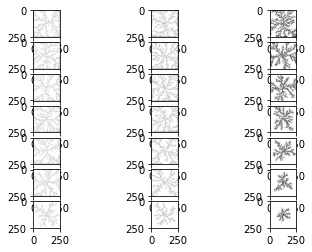

In [63]:
'''Visualise all outputs from DLA'''
# Change inline to qt to visualise the images externally, in a larger resolution.
%matplotlib inline
fig, ax = plt.subplots(7,3)
for idx1, row in enumerate(ax):
    for idx2, fig in enumerate(row):
        fig.imshow(data["images"].iloc[(11*idx1)+(5*idx2)], cmap="Greys")
plt.show()

## Observations

As the stickiness of the particles reduce:
- Patterns seem to have lesser number of branches
- Each branch becomes more dense
- The total area that the pattern covers inside image seems to reduce

## Potential metrics to estimate stickiness

To quantify the change in density we can try and analyse the following parameters,
- Average number of neighbors-per-particle at a distance k (NN@k)

Below is the implementation of the same.

## Visualising variation of Stickiness vs NN@k for observed data

In [64]:
'''NN@k - Number of neighbors at distance k'''
def computeNNK(image, k):
    nz_idxs = zip(*np.nonzero(image))
    min_row = min_col = 0
    max_row, max_col = image.shape[0], image.shape[1]
    nnk = []
    for prow, pcol in nz_idxs:
        rmin, rmax = max(min_row, prow-k), min(max_row, prow+k)
        cmin, cmax = max(min_col, pcol-k), min(max_col, pcol+k)
        neighbors = image[rmin:rmax+1, cmin:cmax+1]
        val = np.sum(neighbors)/neighbors.size
        nnk.append(val)
    return sum(nnk)/len(nnk)

In [65]:
# Compute NN@k for all images and store in the dataframe
data["nnk"] = [computeNNK(img, 1) for img in data.images]

Text(0.5, 1.0, 'NNK (k=1) vs Stickiness')

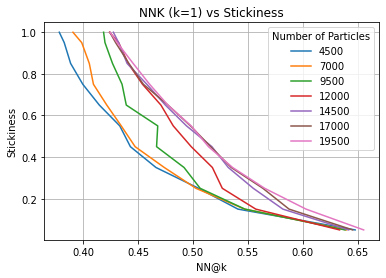

In [66]:
'''Visualise variation of stickiness with NNK for systems with different number of total particles'''
%matplotlib inline

# Group data based on total number of particles in the system
groups = data.groupby(by=["num_particles"])

# Iterate over each group and plot the variation between
# stickiness and NN@k (k=1) for each group
for group_key in groups.groups:
    group = groups.get_group(group_key)
    plt.plot(group.nnk, group.stickiness, label=group_key)
plt.legend(title="Number of Particles")
plt.grid()
plt.xlabel("NN@k")
plt.ylabel("Stickiness")
plt.title("NNK (k=1) vs Stickiness")

## Modelling stickiness based on NN@k and N (number of total particles)

Our intuition that the density increases as stickiness reduces seems to be correct based on the plots above. The factors that can be used to determine stickiness can be as follows:
- NN@k
- Number of total particles in the system

This inverse relationship can probably be modeled using a polynomial regressor of the order 1 or 2. Some example formulation can be as follows, where S is Stickiness, N is the number of particles, x is the input image, and NNK(x) is the average number of particles at a distance k units from each particle.
- $S = (A \times NNK(x)^m) + (B \times N^n) + C$

In this case, we need to determine the parameters A, B, C, m, and n - to most accurately predict the stickiness value, given an input image.

For simplification, we can assume maximum value for $m$ as $m=3$ (highest order for NNK) since we observe an inverse cubic / squared relationship w.r.t. $NNK(x)$ based on the plot. $N$ seems to have a larger effect for higher values of S. The effect seems to reduce at lower S values. This can be modelled by testing $n=1$ and $n=2$. So the estimation models that we'll try are:
1. $S = (A \times NNK(x)^2) + (B \times N^1) + C$
2. $S = (A \times NNK(x)^2) + (B \times N^2) + C$
3. $S = (A \times NNK(x)^2) + (B \times NNK(x)) + (C \times N) + D$
4. $S = (A \times NNK(x)^3) + (B \times NNK(x)^2) + (C \times NNK(x)) + (D \times N) + E$

In [67]:
'''Defining models'''
model1 = lambda image_params, A, B, C : (A*(image_params[0]**2)) + (B*image_params[1]) + C
model2 = lambda image_params, A, B, C : (A*(image_params[0]**2)) + (B*(image_params[1]**2)) + C
model3 = lambda image_params, A, B, C, D : (A*(image_params[0]**2)) + (B*image_params[0]) + (C*image_params[1]) + D
model4 = lambda image_params, A, B, C, D, E : (A*(image_params[0]**3)) + (B*image_params[0]**2) + (C*image_params[0])+ (D*image_params[1]) + E


In [68]:
from scipy.optimize import curve_fit
image_params = data[["nnk","num_particles"]].to_numpy().T
output_data = data["stickiness"].to_numpy()
popt1, pcov1 = curve_fit(model1, image_params, output_data)
popt2, pcov2 = curve_fit(model2, image_params, output_data)
popt3, pcov3 = curve_fit(model3, image_params, output_data)
popt4, pcov4 = curve_fit(model4, image_params, output_data)

Text(0.5, 1.0, 'NNK (k=1) vs Stickiness')

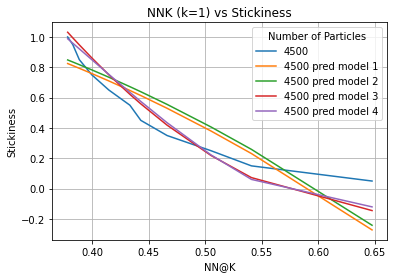

In [69]:
%matplotlib inline
groups = data.groupby(by=["num_particles"])
for group_key in [4500]:
    
    # Plot original
    group = groups.get_group(group_key)
    p = plt.plot(group.nnk, group.stickiness, label=group_key)
    
    # Plot predictions from Model 1
    image_params = group[["nnk", "num_particles"]].to_numpy()
    predicted_stickiness1 = [model1(image_param, *popt1) for image_param in image_params]
    plt.plot(group.nnk, predicted_stickiness1, label=f"{group_key} pred model 1")
    
    # Plot predictions from Model 2
    predicted_stickiness2 = [model2(image_param, *popt2) for image_param in image_params]
    plt.plot(group.nnk, predicted_stickiness2, label=f"{group_key} pred model 2")
    
    # Plot predictions from Model 3
    predicted_stickiness3 = [model3(image_param, *popt3) for image_param in image_params]
    plt.plot(group.nnk, predicted_stickiness3, label=f"{group_key} pred model 3")
    
    # Plot predictions from Model 4
    predicted_stickiness4 = [model4(image_param, *popt4) for image_param in image_params]
    plt.plot(group.nnk, predicted_stickiness4, label=f"{group_key} pred model 4")

plt.legend(title="Number of Particles")
plt.grid()
plt.xlabel("NN@K")
plt.ylabel("Stickiness")
plt.title("NNK (k=1) vs Stickiness")

Clearly, Model 3 & 4 seem to fit the best in this case. Let's plot outputs from model 3 & 4 for all values of N.

## Visualising predictions from Model 3

Text(0.5, 1.0, 'NNK (k=1) vs Predicted Stickiness: Model 3')

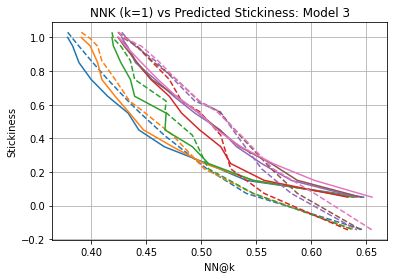

In [70]:
'''Visualising outputs of Model 3 with original'''

%matplotlib inline
for group_key in groups.groups:
    
    # Plot original
    group = groups.get_group(group_key)
    p = plt.plot(group.nnk, group.stickiness, label=group_key)
    
    # Plot predictions from Model 3
    predicted_stickiness3 = [model3(image_param, *popt3) for image_param in image_params]
    plt.plot(group.nnk, predicted_stickiness3, label=f"{group_key} pred", ls="--", color=p[0].get_color())

#plt.legend(title="Number of Particles") # Uncomment when visualising plot using QT based renderer instead of inline
plt.grid()
plt.xlabel("NN@k")
plt.ylabel("Stickiness")
plt.title("NNK (k=1) vs Predicted Stickiness: Model 3")

## Visualising predictions of Model 4

Text(0.5, 1.0, 'NNK (k=1) vs Predicted Stickiness: Model 4')

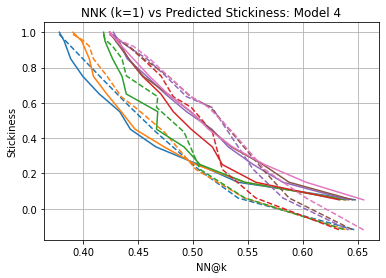

In [71]:
'''Visualising outputs of Model 4 with original'''

%matplotlib inline
for group_key in groups.groups:
    
    # Plot original
    group = groups.get_group(group_key)
    p = plt.plot(group.nnk, group.stickiness, label=group_key)
    
    # Plot predictions from Model 3
    predicted_stickiness4 = [model4(image_param, *popt4) for image_param in image_params]
    plt.plot(group.nnk, predicted_stickiness4, label=f"{group_key} pred", ls="--", color=p[0].get_color())

#plt.legend(title="Number of Particles") # Uncomment when visualising plot using QT based renderer instead of inline
plt.grid()
plt.xlabel("NN@k")
plt.ylabel("Stickiness")
plt.title("NNK (k=1) vs Predicted Stickiness: Model 4")

## Conclusion

Model 4 seems to do much better when the stickiness is higher, while both model 3 and 4 seem to predict negative values when the stickiness is low. accurately estimate the stickiness based on NN@k (k=1), hence the current-best model seems to be Model 4 i.e.
- $S = (A \times NNK(x)^3) + (B \times NNK(x)^2) + (C \times NNK(x)) + (D \times N) + E$

where,

$A = 38.56$\
$B = -45.55$\
$C = 11.47$\
$D = 2.16 \times 10^{-5}$\
$E = 0.98$

## What else could be done?

1. The model could be fit on a subset of DLA outputs and the accuracy of the model can be estimated on unseen DLA simulations. This would help us understand if our model makes good predictions or not.
2. All models above seem to predict negative values when stickiness is low. This could be solved by either clipping the model output to a minimum such as 0.001, or by adding more complexity into the model, and/or by adding more constraints on the outputs of the model.